In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
np.random.seed(42) # Set random seed for reproducibility

In [4]:
# Activation functions and their derivatives
def relu(x):
    """ReLU activation function"""
    return np.maximum(0, x)

def relu_derivative(x):
    """Derivative of ReLU function"""
    return np.where(x > 0, 1, 0)

def softmax(x):
    """Softmax activation function"""
    # Subtract max for numerical stability and to avoid getting a huge positive number after exponentiating
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

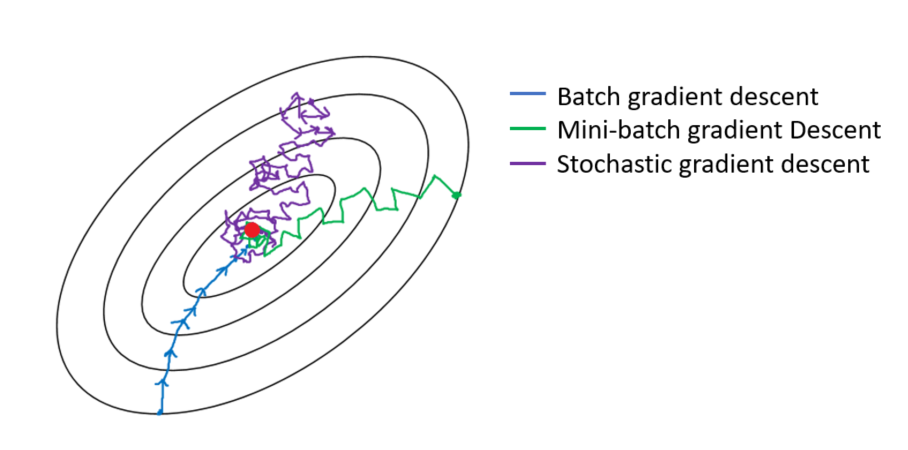

In [5]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        """Initialize the neural network with given layer sizes"""
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Initialize weights and biases
        # Use He initialization for better gradient flow
        self.W1 = np.random.randn(self.input_size, self.hidden_size) * np.sqrt(2 / self.input_size)
        self.b1 = np.zeros((1, self.hidden_size))
        self.W2 = np.random.randn(self.hidden_size, self.output_size) * np.sqrt(2 / self.hidden_size)
        self.b2 = np.zeros((1, self.output_size))
    
    def forward(self, X):
        """Forward pass through the network"""
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = relu(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = softmax(self.z2)
        return self.a2
    
    def backward(self, X, y, output, learning_rate):
        """Backward pass to update weights and biases"""
        batch_size = X.shape[0]
        
        # Output layer
        delta2 = output - y  # Error at output layer
        # delta2 shape: (batch_size, output_size)
        
        # Transposition for dW2: (hidden_size, batch_size) dot (batch_size, output_size)
        # Result: (hidden_size, output_size), matching W2's shape
        # We transpose self.a1 which originally has shape (batch_size, hidden_size) to align the dimensions for the dot product
        dW2 = np.dot(self.a1.T, delta2) / batch_size
        
        # Sum along axis=0 (batch dimension) to get the average gradient for each output neuron
        # axis=0 corresponds to the batch dimension because delta2 has shape (batch_size, output_size)
        # keepdims=True ensures the result has shape (1, output_size) instead of (output_size,)
        # This maintains compatibility for broadcasting in future calculations
        db2 = np.sum(delta2, axis=0, keepdims=True) / batch_size
        
        # Hidden layer
        # Transposition of W2: (output_size, hidden_size)
        # This aligns with delta2 (batch_size, output_size) for the dot product
        delta1 = np.dot(delta2, self.W2.T) * relu_derivative(self.a1)
        # delta1 shape: (batch_size, hidden_size)
        
        # Transposition for dW1: (input_size, batch_size) dot (batch_size, hidden_size)
        # Result: (input_size, hidden_size), matching W1's shape
        # We transpose X to align the dimensions for the dot product
        dW1 = np.dot(X.T, delta1) / batch_size
        
        # Sum along axis=0 (batch dimension) to get the average gradient for each hidden neuron
        # axis=0 corresponds to the batch dimension because delta1 has shape (batch_size, hidden_size)
        # keepdims=True ensures the result has 2d shape (1, hidden_size) instead of 1d shape (hidden_size,)
        # This maintains compatibility for broadcasting in future calculations
        db1 = np.sum(delta1, axis=0, keepdims=True) / batch_size
        
        # Update weights and biases
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
    
    def train(self, X, y, epochs, learning_rate, batch_size=32):
        """Train the neural network using mini-batch gradient descent"""
        # Mini-batch gradient descent:
        # This method splits the training data into small batches that are used to calculate model error and update model coefficients.
        # Advantages of mini-batch:
        # 1. More robust convergence, avoiding local minima
        # 2. More stable and less noisy gradient estimates compared to stochastic gradient descent
        # 3. Can leverage matrix optimizations of batch methods
        # 4. Requires less memory compared to batch gradient descent
        
        # Alternatives to mini-batch:
        # 1. Batch Gradient Descent:
        #    - Uses the entire dataset to compute the gradient of the cost function
        #    - Pros: Stable convergence; optimal for convex problems
        #    - Cons: Slow for large datasets; can get stuck in local minima
        #    - To implement: Remove the inner loop and use the entire X and y for each epoch
        
        # 2. Stochastic Gradient Descent (SGD):
        #    - Uses a single example at each iteration to compute the gradient
        #    - Pros: Faster; can escape local minima more easily
        #    - Cons: High variance in model parameters; may not converge to the exact minimum
        #    - To implement: Set batch_size to 1
        
        for epoch in range(epochs):
            # Mini-batch training
            for i in range(0, X.shape[0], batch_size):
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                
                output = self.forward(X_batch)
                self.backward(X_batch, y_batch, output, learning_rate)
            
            # Print progress every 10 epochs
            if epoch % 10 == 0:
                output = self.forward(X)
                # Calculate cross-entropy loss
                # Cross-entropy loss measures the performance of a classification model 
                # whose output is a probability value between 0 and 1.
                # It increases as the predicted probability diverges from the actual label.
                # We add a small epsilon (1e-8) to avoid log(0) which is undefined.
                # np.sum(y * np.log(output + 1e-8), axis=1) sums along axis=1 (feature dimension)
                # to get the loss for each sample in the batch
                loss = -np.mean(np.sum(y * np.log(output + 1e-8), axis=1))
                
                # Calculate accuracy
                # Accuracy is the proportion of correct predictions (both true positives and true negatives) 
                # among the total number of cases examined.
                # np.argmax gets the index of the highest probability (our prediction)
                # We compare this with the true label (also converted to index with np.argmax)
                # np.mean calculates the proportion of correct predictions
                # axis=1 in np.argmax finds the maximum along the feature dimension
                accuracy = np.mean(np.argmax(output, axis=1) == np.argmax(y, axis=1))
                print(f"Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
        
        # Print final results
        output = self.forward(X)
        loss = -np.mean(np.sum(y * np.log(output + 1e-8), axis=1))
        accuracy = np.mean(np.argmax(output, axis=1) == np.argmax(y, axis=1))
        print(f"FINAL | Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
    
    def predict(self, X):
        """Make predictions on new data"""
        return self.forward(X)

In [6]:
# Load and preprocess data
print("Loading data...")
data = pd.read_csv('data.csv')
print("Data shape:", data.shape)

# Split data
train_data = data.iloc[:33600]  # 80% for training
test_data = data.iloc[33600:]   # 20% for testing

# Separate features and labels
X_train = train_data.iloc[:, 1:].values / 255.0  # Normalize pixel values
y_train = train_data.iloc[:, 0].values

X_test = test_data.iloc[:, 1:].values / 255.0
y_test = test_data.iloc[:, 0].values

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# One-hot encode labels
y_train_encoded = np.eye(10)[y_train]
y_test_encoded = np.eye(10)[y_test]

Loading data...
Data shape: (42000, 785)
X_train shape: (33600, 784)
y_train shape: (33600,)


In [7]:
# Initialize and train the neural network
input_size = 784  # 28x28 pixels
hidden_size = 128
output_size = 10  # 10 digits

print("Initializing neural network...")
nn = NeuralNetwork(input_size, hidden_size, output_size)

print("Starting training...")
nn.train(X_train, y_train_encoded, epochs=50, learning_rate=0.1, batch_size=32)

Initializing neural network...
Starting training...
Epoch 0, Loss: 0.2217, Accuracy: 0.9349
Epoch 10, Loss: 0.0322, Accuracy: 0.9923
Epoch 20, Loss: 0.0108, Accuracy: 0.9985
Epoch 30, Loss: 0.0047, Accuracy: 0.9998
Epoch 40, Loss: 0.0027, Accuracy: 1.0000
FINAL | Epoch 49, Loss: 0.0019, Accuracy: 1.0000


In [8]:
# Evaluate the model
print("Evaluating the model...")
predictions = nn.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
accuracy = np.mean(predicted_labels == y_test)
print(f"Test accuracy: {accuracy:.4f}")

Evaluating the model...
Test accuracy: 0.9756


Sample of predictions: [0 7 7 2 2 6 5 7 8 5 3 0 2 7 6 9 2 3 5 1]
Sample of true labels: [0 7 7 2 2 6 5 7 8 5 3 0 2 7 6 9 2 3 5 1]


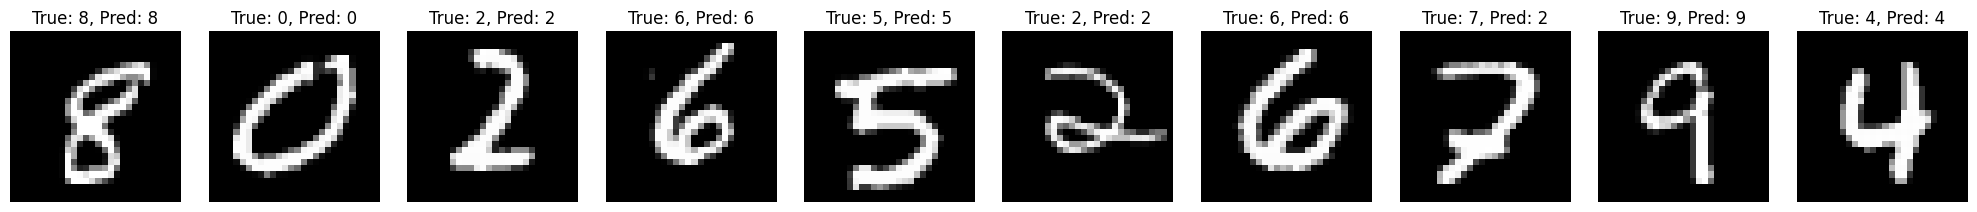

In [9]:
print("Sample of predictions:", predicted_labels[:20])
print("Sample of true labels:", y_test[:20])

# Function to plot digits
def plot_digits(X, y_true, y_pred, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.title(f"True: {y_true[i]}, Pred: {y_pred[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Get predictions for some test samples
n_samples = 10
sample_indices = np.random.choice(len(X_test), n_samples, replace=False)
X_samples = X_test[sample_indices]
y_true = y_test[sample_indices]
y_pred = np.argmax(nn.predict(X_samples), axis=1)

# Plot the results
plot_digits(X_samples, y_true, y_pred)

Incorrect predictions:


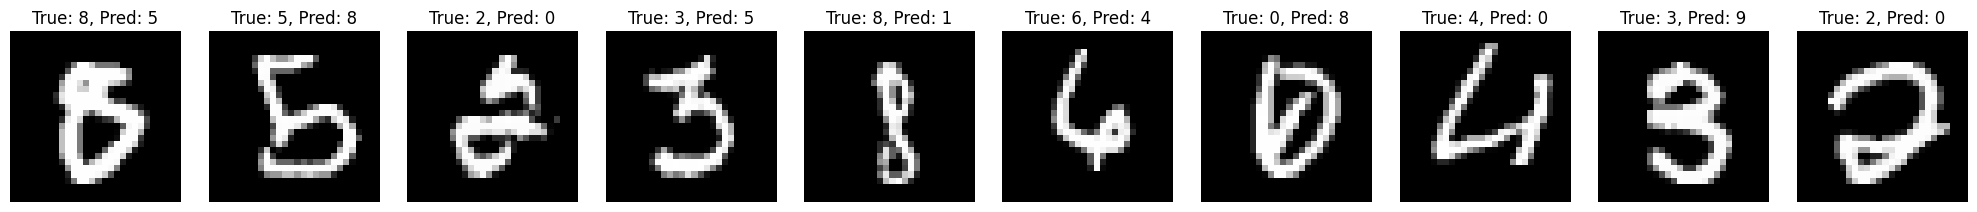

In [10]:
# Function to find incorrect predictions
def find_incorrect_predictions(X, y_true, y_pred, n=10):
    incorrect_indices = np.where(y_true != y_pred)[0]
    if len(incorrect_indices) == 0:
        print("No incorrect predictions found in the sample.")
        return None, None, None
    n = min(n, len(incorrect_indices))
    sample_indices = np.random.choice(incorrect_indices, n, replace=False)
    return X[sample_indices], y_true[sample_indices], y_pred[sample_indices]

# Find and plot incorrect predictions
n_samples = 10
X_incorrect, y_true_incorrect, y_pred_incorrect = find_incorrect_predictions(X_test, y_test, predicted_labels, n_samples)

print("Incorrect predictions:")
if X_incorrect is not None:
    
    # Plot the incorrect predictions
    plot_digits(X_incorrect, y_true_incorrect, y_pred_incorrect)
else:
    print("No incorrect predictions found in the entire test set.")

In [11]:
# Print overall model performance
print("\nOverall model performance:")
print("Sample of predictions:", predicted_labels[:20])
print("Sample of true labels:", y_test[:20])
print(f"Total incorrect predictions: {np.sum(predicted_labels != y_test)} out of {len(y_test)} total")
print(f"Accuracy: {accuracy:.4f}")


Overall model performance:
Sample of predictions: [0 7 7 2 2 6 5 7 8 5 3 0 2 7 6 9 2 3 5 1]
Sample of true labels: [0 7 7 2 2 6 5 7 8 5 3 0 2 7 6 9 2 3 5 1]
Total incorrect predictions: 205 out of 8400 total
Accuracy: 0.9756
